In [15]:
from argparse import ArgumentParser

import torch
import wandb
import numpy as np
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from preprocessing.data_pipeline import build_data_pipeline
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger
from preprocessing.preprocess_ucr import UCRDatasetImporter
from experiments.exp_maskgit import ExpMaskGIT
from evaluation.model_eval import Evaluation
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from models.stage2.maskgit import MaskGIT
import os
from pathlib import Path
import tempfile

# from evaluation.evaluation import Evaluation
from utils import (
    get_root_dir,
    load_yaml_param_settings,
    save_model,
    model_filename,
)



config_dir = get_root_dir().joinpath("configs", "config.yaml")
dataset="UWaveGestureLibraryAll"
config = load_yaml_param_settings(config_dir)
config["dataset"]["dataset_name"] = dataset

dataset_importer = UCRDatasetImporter(**config["dataset"])
batch_size = config["dataset"]["batch_sizes"]["stage1"]

train_data_loader_no_aug = build_data_pipeline(
    batch_size, dataset_importer, config, augment=False, kind="train"
)

input_length = train_data_loader_no_aug.dataset.X.shape[-1]

n_classes = len(np.unique(train_data_loader_no_aug.dataset.Y))

maskgit = MaskGIT(
    input_length,
    **config["MaskGIT"],
    config=config,
    n_classes=n_classes,
)

# load
fname = f"maskgit-{dataset}.ckpt"
try:
    ckpt_fname = os.path.join("saved_models", fname)
    maskgit.load_state_dict(torch.load(ckpt_fname), strict=False)
except FileNotFoundError:
    ckpt_fname = Path(tempfile.gettempdir()).joinpath(fname)
    maskgit.load_state_dict(torch.load(ckpt_fname), strict=False)



self.X_train.shape: (896, 945)
self.X_test.shape: (3582, 945)
# unique labels (train): [0 1 2 3 4 5 6 7]
# unique labels (test): [0 1 2 3 4 5 6 7]
/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/saved_models
encoder-UWaveGestureLibraryAll.ckpt
 encoder loaded
/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/saved_models
decoder-UWaveGestureLibraryAll.ckpt
 decoder loaded
/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/saved_models
vqmodel-UWaveGestureLibraryAll.ckpt
 vqmodel loaded


In [2]:
eval = Evaluation(dataset, 0, config, batch_size)

self.X_train.shape: (896, 945)
self.X_test.shape: (3582, 945)
# unique labels (train): [0 1 2 3 4 5 6 7]
# unique labels (test): [0 1 2 3 4 5 6 7]


In [3]:
samples, agg_probs, agg_entropy, agg_sel_entropy  = eval.aggregate_statistics(maskgit, 1000)

100%|██████████| 1000/1000 [00:45<00:00, 22.17it/s]


In [4]:
co_occurence = eval.co_occurence_matrix(samples, maskgit.mask_token_ids)

Text(0.5, 1.0, 'Off Diagonal Pointwise Mutual Information of Tokens')

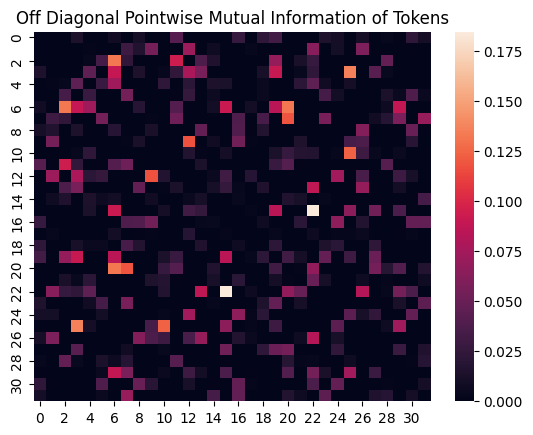

In [55]:
token_prob, joint_prob, conditional_prob = eval.calculate_probabilities(co_occurence)

pmi = eval.calculate_pmi(token_prob, joint_prob)

pmi = pmi.fill_diagonal_(0)
sns.heatmap(pmi)
plt.title("Off Diagonal Pointwise Mutual Information of Tokens")


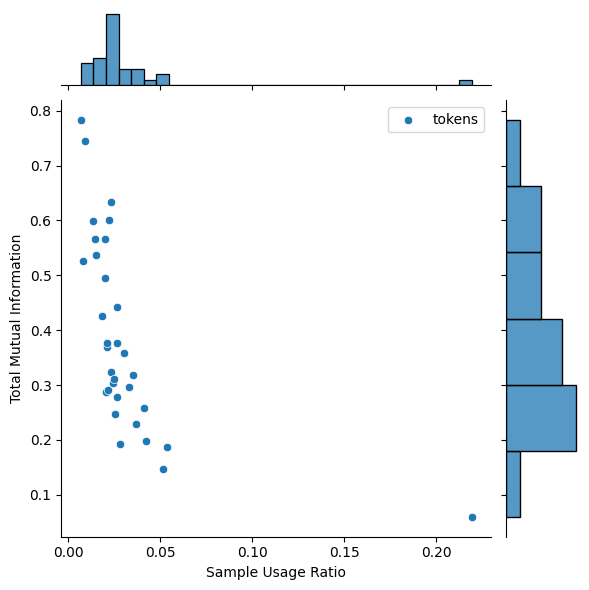

In [72]:
tpmi = pmi.sum(axis=0)

sorted_indicies = torch.argsort(token_prob)

most_sampled = token_prob[sorted_indicies]
corr_tpmi = tpmi[sorted_indicies]

df = pd.DataFrame({
    "Sample Usage Ratio": most_sampled,
    "Total Mutual Information": corr_tpmi
})

sns.jointplot(data=df, x='Sample Usage Ratio', y='Total Mutual Information', label="token indicies")
# Show the plot
plt.show()

tensor([[0.0018, 0.0012, 0.0007,  ..., 0.0010, 0.0008, 0.0010],
        [0.0012, 0.0017, 0.0007,  ..., 0.0009, 0.0008, 0.0009],
        [0.0007, 0.0007, 0.0007,  ..., 0.0005, 0.0004, 0.0005],
        ...,
        [0.0010, 0.0009, 0.0005,  ..., 0.0011, 0.0005, 0.0006],
        [0.0008, 0.0008, 0.0004,  ..., 0.0005, 0.0007, 0.0006],
        [0.0010, 0.0009, 0.0005,  ..., 0.0006, 0.0006, 0.0010]])


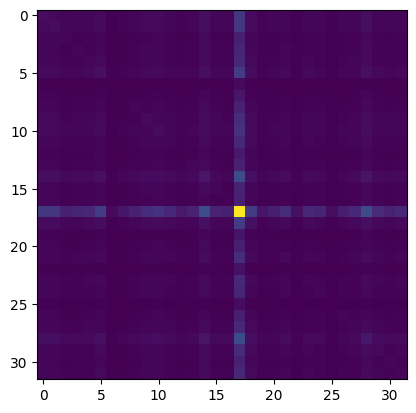

In [13]:
# Calculate the total sum of the matrix
total_sum = torch.sum(co_occurence)

# Calculate the probability of each token
token_prob = torch.sum(co_occurence, dim=0) / total_sum

# Calculate the joint probability of each pair of tokens
joint_prob = co_occurence / total_sum

print(joint_prob)
eps = 1e-10
# Ensure probabilities are normalized
token_prob = token_prob / token_prob.sum()
joint_prob = joint_prob / joint_prob.sum()

# Make sure the denominator is non-zero
denominator = torch.outer(token_prob, token_prob)
denominator = torch.clamp(denominator, min=eps)

# Calculate the mutual information
mutual_info = joint_prob / denominator
mutual_info = torch.clamp(mutual_info, min=eps)  # Ensure it's non-zero before taking log
mutual_info = torch.log2(mutual_info)
mutual_info = joint_prob * mutual_info  # joint_prob should multiply after taking log

# Mutual information should be non-negative; clamp it just in case
mutual_info = torch.clamp(mutual_info, min=0.0)

plt.imshow(joint_prob)

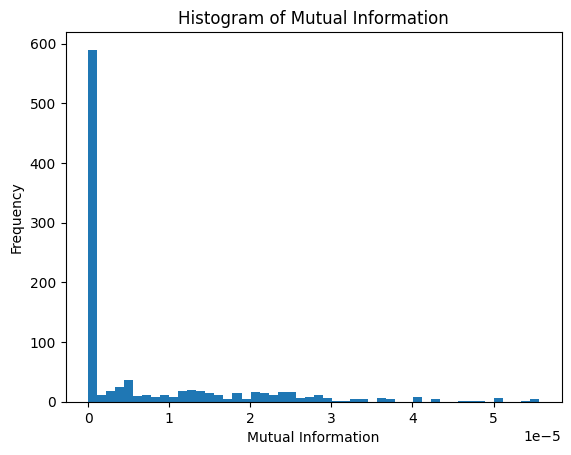

In [14]:
mutual_info = mutual_info.cpu().numpy()
mutual_info_no_diag = mutual_info.copy()
np.fill_diagonal(mutual_info_no_diag, np.nan)

# Flatten the matrix and remove NaN values
mutual_info_flat = mutual_info_no_diag.flatten()
mutual_info_flat = mutual_info_flat[~np.isnan(mutual_info_flat)]

# Plot the histogram
plt.hist(mutual_info_flat, bins=50)
plt.title('Histogram of Mutual Information')
plt.xlabel('Mutual Information')
plt.ylabel('Frequency')
plt.show()

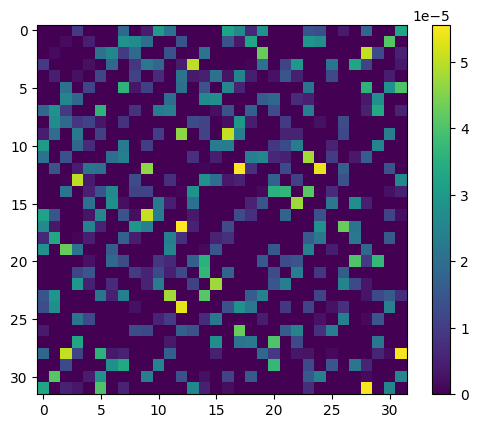

In [15]:
np.fill_diagonal(mutual_info, 0)
plt.imshow(mutual_info, interpolation="nearest")
plt.colorbar()
plt.show()

In [16]:
plt.imshow(conditional_prob)

NameError: name 'conditional_prob' is not defined

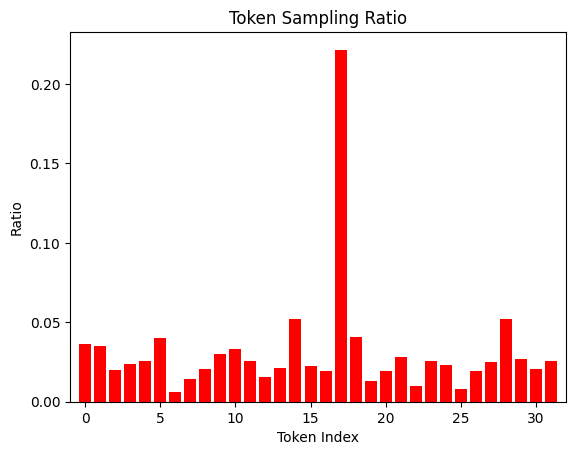

In [17]:
f, a = plt.subplots()

a, probs = eval.plot_prior_token_ratios(a, samples)

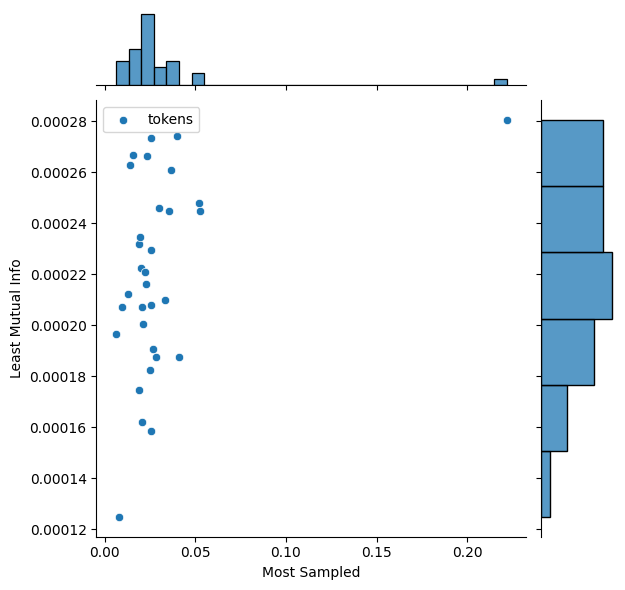

In [18]:
total_mutual_info = mutual_info.sum(axis=0)

# Assuming `samples` is a list of sample counts for each token
samples = np.array(probs)

# Sort tokens by sample count
sorted_indices = np.argsort(samples)

# Get the tokens with the most samples and least mutual information
most_sampled = samples[sorted_indices]
least_mutual_info = total_mutual_info[sorted_indices]

# Plot
import seaborn as sns
import pandas as pd

# Create a DataFrame for seaborn
df = pd.DataFrame({
    'Most Sampled': most_sampled,
    'Least Mutual Info': least_mutual_info
})

# Create the joint plot
sns.jointplot(data=df, x='Most Sampled', y='Least Mutual Info', label="tokens")

# Show the plot
plt.show()

AttributeError: PathCollection.set() got an unexpected keyword argument 'bins'

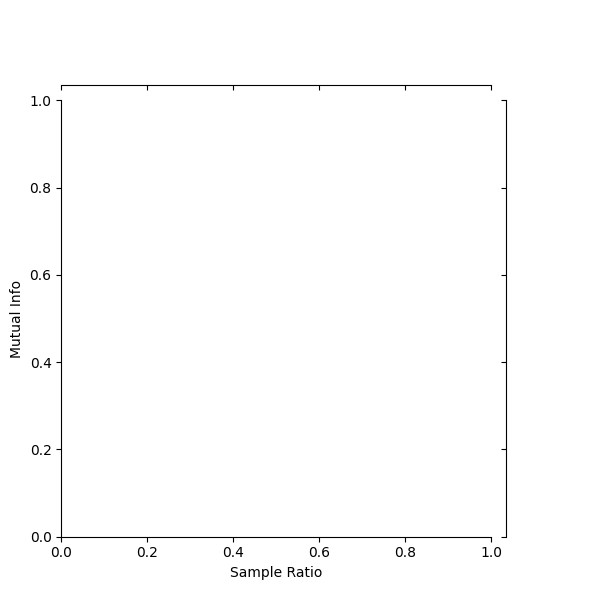

In [108]:
import seaborn as sns
import pandas as pd

# Create a DataFrame for seaborn
df = pd.DataFrame({
    'Sample Ratio': most_sampled,
    'Mutual Info': least_mutual_info
})

# Create the jointplot
jointplot = sns.jointplot(x='Sample Ratio', y='Mutual Info', data=df, label='tokens', bins=10)

# Show the plot
plt.show()

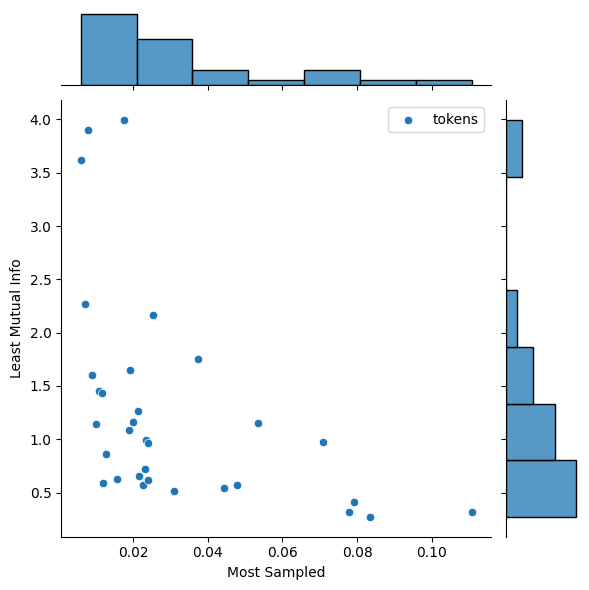

In [109]:
import seaborn as sns

# Create a DataFrame for seaborn
df = pd.DataFrame({
    'Most Sampled': most_sampled,
    'Least Mutual Info': least_mutual_info
})

# Create the joint plot
sns.jointplot(data=df, x='Most Sampled', y='Least Mutual Info', label="tokens")

# Show the plot
plt.show()

In [ ]:
sns